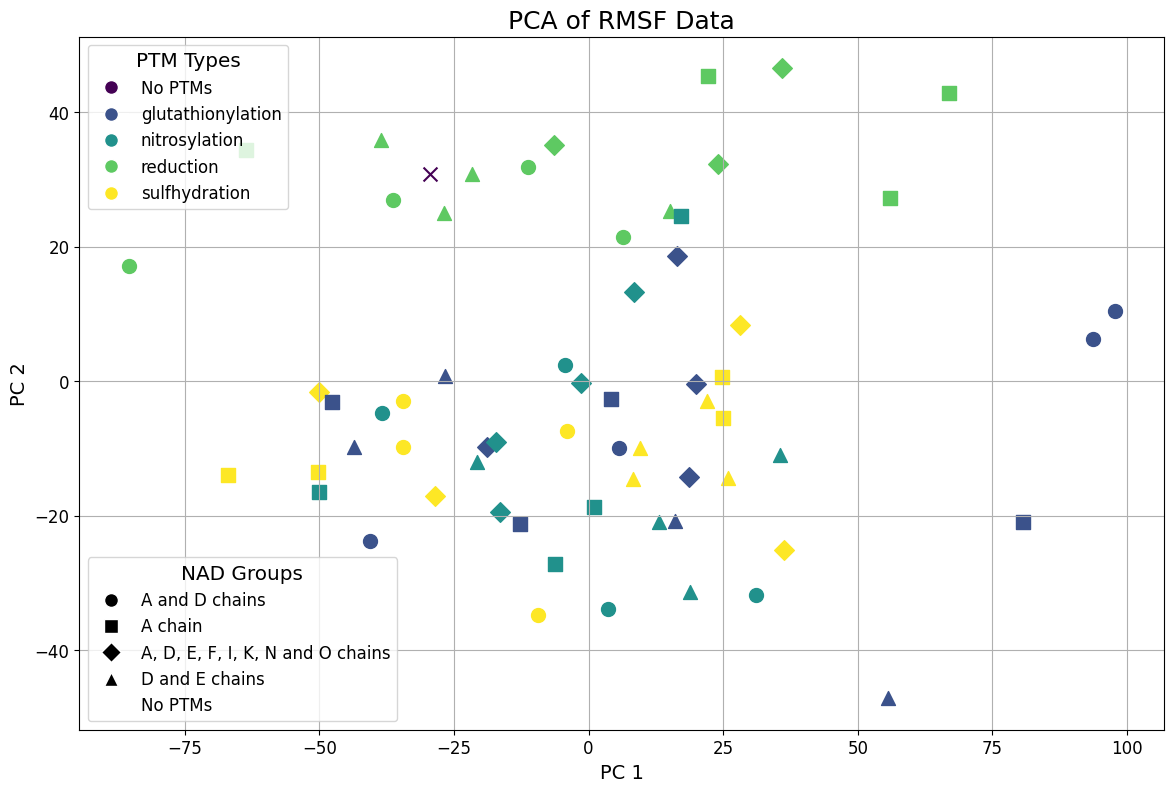

In [22]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Mapping of numerical labels to PTM types
PTM_TYPES = {
    "0000": "reduction",
    "0001": "nitrosylation",
    "0002": "sulfhydration",
    "0003": "glutathionylation",
    "0004": "nitrosylation",
    "0005": "sulfhydration",
    "0006": "glutathionylation",
    "0007": "nitrosylation",
    "0008": "sulfhydration",
    "0009": "glutathionylation",
    "0010": "nitrosylation",
    "0011": "sulfhydration",
    "0012": "glutathionylation",
    "0013": "reduction",
    "0014": "reduction",
    "0015": "reduction"
}

def extract_nad_variation(path):
    postprocess_part = path.split("/postprocess/")[1]
    nad_variation = postprocess_part.split("/")[0]
    if 'no_PTM' in nad_variation:
        return "No PTMs"
    parts = nad_variation.split('_')
    if len(parts) > 2:
        chains = parts[2]
        if len(chains) == 1:
            return f"{chains} chain"
        elif len(chains) > 1:
            return f"{', '.join(list(chains[:-1]))} and {chains[-1]} chains"
    return nad_variation

rmsf_data = {base_path: [] for base_path in [
    "/anfhome/shared/qipd/newmds/postprocess/no_PTM/randomstring",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_ADEFIKNO/1280ec92-875e-450d-966b-4550ebedc82e",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_AD/eda6b09c-b9f2-42c9-be15-0204ed29807a"
]}

# Collect data
for base_path in rmsf_data:
    for i in range(16):  # from 0000 to 0015
        file_path = os.path.join(base_path, f'{i:04d}', 'rmsf', f'{i:04d}_rmsf.xvg')
        
        if os.path.exists(file_path):
            with open(file_path, "r") as fh:
                rmsf = fh.readlines()
            rmsf = rmsf[17:] 
            rmsf_value = [float(line.split()[1]) for line in rmsf]
            label = f"{i:04d}"
            rmsf_data[base_path].append((label, rmsf_value))

# Find the maximum length of RMSF vectors
max_length = max(len(values) for base_path in rmsf_data.values() for _, values in base_path)

# Pad RMSF vectors to the same length
for base_path, data_list in rmsf_data.items():
    for idx, (label, values) in enumerate(data_list):
        padded_values = np.pad(values, (0, max_length - len(values)), 'constant', constant_values=np.nan)
        rmsf_data[base_path][idx] = (label, padded_values)

# Flatten and prepare data for PCA
dataset = []
labels = []
nad_groups = []
for base_path, data in rmsf_data.items():
    nad_variation = extract_nad_variation(base_path)
    
    for label, rmsf_value in data:
        dataset.append(rmsf_value)
        if "no_PTM" in base_path:
            labels.append("No PTMs")
        else:
            labels.append(PTM_TYPES[label])
        nad_groups.append(nad_variation)

# Impute the missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
dataset_imputed = imputer.fit_transform(dataset)

# Standardize the dataset
scaler = StandardScaler()
dataset_std = scaler.fit_transform(dataset_imputed)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataset_std)

# Plotting the PCA results
fig, ax = plt.subplots(figsize=(14, 9))
unique_labels = sorted(set(labels))
unique_nad_groups = sorted(set(nad_groups))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
markers = ['o', 's', 'D', '^', 'x']  # Different markers for NAD groups

# Create a mapping for color and marker
label_color_mapping = {label: color for label, color in zip(unique_labels, colors)}
nad_group_marker_mapping = {nad_group: markers[i % len(markers)] for i, nad_group in enumerate(unique_nad_groups)}

# Plot each point with the corresponding color and marker
for i, (pc1, pc2) in enumerate(pca_result):
    ax.scatter(
        pc1, pc2,
        color=label_color_mapping[labels[i]],
        marker=nad_group_marker_mapping[nad_groups[i]],
        label=f"{labels[i]}, {nad_groups[i]}",
        s=100  # Set marker size
    )

# Create color legend
label_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
    for label, color in label_color_mapping.items()
]
ax.add_artist(plt.legend(handles=label_handles, title="PTM Types", loc='upper left', fontsize='large', title_fontsize='x-large'))

# Create marker legend
marker_handles = [
    plt.Line2D([0], [0], marker=marker, color='w', label=nad_group, markerfacecolor='k', markersize=10)
    for nad_group, marker in nad_group_marker_mapping.items()
]
ax.legend(handles=marker_handles, title="NAD Groups", loc='lower left', fontsize='large', title_fontsize='x-large')

# Plot configurations
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_title('PCA of RMSF Data', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.savefig("PCA_RMSF1.png")
plt.show()

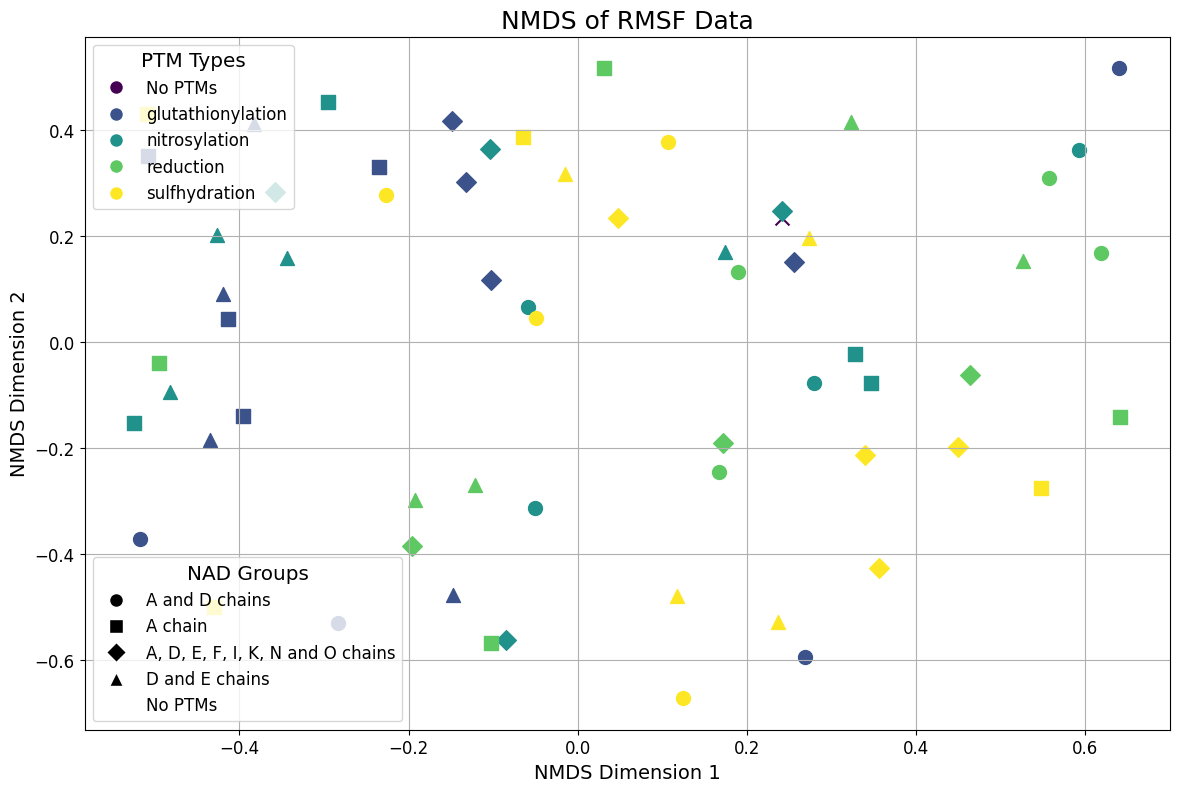

In [17]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import pairwise_distances

# Mapping of numerical labels to PTM types
PTM_TYPES = {
    "0000": "reduction",
    "0001": "nitrosylation",
    "0002": "sulfhydration",
    "0003": "glutathionylation",
    "0004": "nitrosylation",
    "0005": "sulfhydration",
    "0006": "glutathionylation",
    "0007": "nitrosylation",
    "0008": "sulfhydration",
    "0009": "glutathionylation",
    "0010": "nitrosylation",
    "0011": "sulfhydration",
    "0012": "glutathionylation",
    "0013": "reduction",
    "0014": "reduction",
    "0015": "reduction"
}

def extract_nad_variation(path):
    postprocess_part = path.split("/postprocess/")[1]
    nad_variation = postprocess_part.split("/")[0]
    if 'no_PTM' in nad_variation:
        return "No PTMs"
    parts = nad_variation.split('_')
    if len(parts) > 2:
        chains = parts[2]
        if len(chains) == 1:
            return f"{chains} chain"
        elif len(chains) > 1:
            return f"{', '.join(list(chains[:-1]))} and {chains[-1]} chains"
    return nad_variation

rmsf_data = {base_path: [] for base_path in [
    "/anfhome/shared/qipd/newmds/postprocess/no_PTM/randomstring",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_ADEFIKNO/1280ec92-875e-450d-966b-4550ebedc82e",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_AD/eda6b09c-b9f2-42c9-be15-0204ed29807a"
]}

# Collect data
for base_path in rmsf_data:
    for i in range(16): # from 0000 to 0015
        file_path = os.path.join(base_path, f'{i:04d}', 'rmsf', f'{i:04d}_rmsf.xvg')
        if os.path.exists(file_path):
            with open(file_path, "r") as fh:
                rmsf = fh.readlines()
                rmsf = rmsf[17:]
                rmsf_value = [float(line.split()[1]) for line in rmsf]
                label = f"{i:04d}"
                rmsf_data[base_path].append((label, rmsf_value))

# Find the maximum length of RMSF vectors
max_length = max(len(values) for base_path in rmsf_data.values() for _, values in base_path)

# Pad RMSF vectors to the same length
for base_path, data_list in rmsf_data.items():
    for idx, (label, values) in enumerate(data_list):
        padded_values = np.pad(values, (0, max_length - len(values)), 'constant', constant_values=np.nan)
        rmsf_data[base_path][idx] = (label, padded_values)

# Flatten and prepare data for NMDS
dataset = []
labels = []
nad_groups = []
for base_path, data in rmsf_data.items():
    nad_variation = extract_nad_variation(base_path)
    for label, rmsf_value in data:
        dataset.append(rmsf_value)
        if "no_PTM" in base_path:
            labels.append("No PTMs")
        else:
            labels.append(PTM_TYPES[label])
        nad_groups.append(nad_variation)

# Impute the missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
dataset_imputed = imputer.fit_transform(dataset)

# Standardize the dataset
scaler = StandardScaler()
dataset_std = scaler.fit_transform(dataset_imputed)

# Compute the distance matrix using euclidean distance
distance_matrix = pairwise_distances(dataset_std, metric='euclidean')

# Perform NMDS
nmds = MDS(n_components=2, metric=False, dissimilarity='precomputed', random_state=42)
nmds_result = nmds.fit_transform(distance_matrix)

# Plotting the NMDS results
fig, ax = plt.subplots(figsize=(14, 9))
unique_labels = sorted(set(labels))
unique_nad_groups = sorted(set(nad_groups))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
markers = ['o', 's', 'D', '^', 'x'] # Different markers for NAD groups

# Create a mapping for color and marker
label_color_mapping = {label: color for label, color in zip(unique_labels, colors)}
nad_group_marker_mapping = {nad_group: markers[i % len(markers)] for i, nad_group in enumerate(unique_nad_groups)}

# Plot each point with the corresponding color and marker
for i, (dim1, dim2) in enumerate(nmds_result):
    ax.scatter(
        dim1, dim2,
        color=label_color_mapping[labels[i]],
        marker=nad_group_marker_mapping[nad_groups[i]],
        label=f"{labels[i]}, {nad_groups[i]}",
        s=100 # Set marker size
    )

# Create color legend
label_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
    for label, color in label_color_mapping.items()
]
ax.add_artist(plt.legend(handles=label_handles, title="PTM Types", loc='upper left', fontsize='large', title_fontsize='x-large'))

# Create marker legend
marker_handles = [
    plt.Line2D([0], [0], marker=marker, color='w', label=nad_group, markerfacecolor='k', markersize=10)
    for nad_group, marker in nad_group_marker_mapping.items()
]
ax.legend(handles=marker_handles, title="NAD Groups", loc='lower left', fontsize='large', title_fontsize='x-large')

# Plot configurations
ax.set_xlabel('NMDS Dimension 1', fontsize=14)
ax.set_ylabel('NMDS Dimension 2', fontsize=14)
ax.set_title('NMDS of RMSF Data', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.savefig("NMDS_RMSF.png")
plt.show()

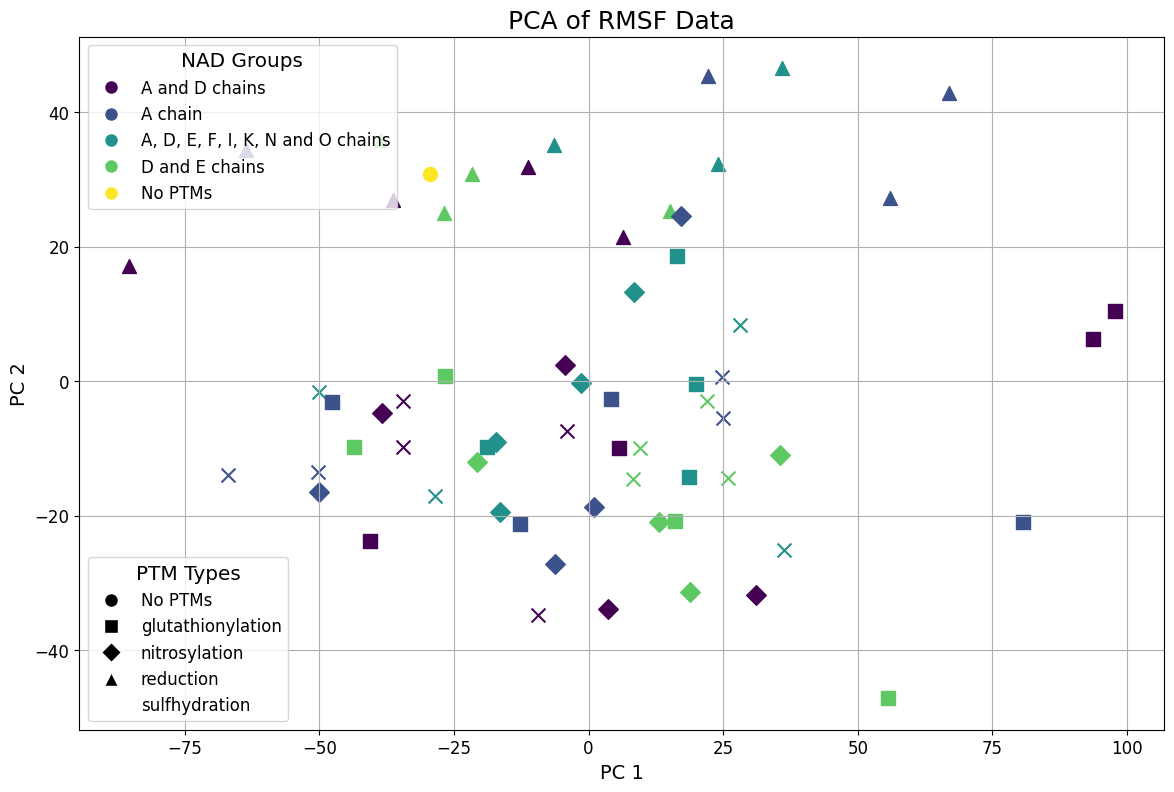

In [18]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import pairwise_distances

# Mapping of numerical labels to PTM types
PTM_TYPES = {
    "0000": "reduction",
    "0001": "nitrosylation",
    "0002": "sulfhydration",
    "0003": "glutathionylation",
    "0004": "nitrosylation",
    "0005": "sulfhydration",
    "0006": "glutathionylation",
    "0007": "nitrosylation",
    "0008": "sulfhydration",
    "0009": "glutathionylation",
    "0010": "nitrosylation",
    "0011": "sulfhydration",
    "0012": "glutathionylation",
    "0013": "reduction",
    "0014": "reduction",
    "0015": "reduction"
}

def extract_nad_variation(path):
    postprocess_part = path.split("/postprocess/")[1]
    nad_variation = postprocess_part.split("/")[0]
    if 'no_PTM' in nad_variation:
        return "No PTMs"
    parts = nad_variation.split('_')
    if len(parts) > 2:
        chains = parts[2]
        if len(chains) == 1:
            return f"{chains} chain"
        elif len(chains) > 1:
            return f"{', '.join(list(chains[:-1]))} and {chains[-1]} chains"
    return nad_variation

rmsf_data = {base_path: [] for base_path in [
    "/anfhome/shared/qipd/newmds/postprocess/no_PTM/randomstring",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_ADEFIKNO/1280ec92-875e-450d-966b-4550ebedc82e",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584",
    "/anfhome/shared/qipd/newmds/postprocess/NAD_in_AD/eda6b09c-b9f2-42c9-be15-0204ed29807a"
]}

# Collect data
for base_path in rmsf_data:
    for i in range(16):  # from 0000 to 0015
        file_path = os.path.join(base_path, f'{i:04d}', 'rmsf', f'{i:04d}_rmsf.xvg')
        
        if os.path.exists(file_path):
            with open(file_path, "r") as fh:
                rmsf = fh.readlines()
            rmsf = rmsf[17:] 
            rmsf_value = [float(line.split()[1]) for line in rmsf]
            label = f"{i:04d}"
            rmsf_data[base_path].append((label, rmsf_value))

# Find the maximum length of RMSF vectors
max_length = max(len(values) for base_path in rmsf_data.values() for _, values in base_path)

# Pad RMSF vectors to the same length
for base_path, data_list in rmsf_data.items():
    for idx, (label, values) in enumerate(data_list):
        padded_values = np.pad(values, (0, max_length - len(values)), 'constant', constant_values=np.nan)
        rmsf_data[base_path][idx] = (label, padded_values)

# Flatten and prepare data for NMDS
dataset = []
labels = []
nad_groups = []
for base_path, data in rmsf_data.items():
    nad_variation = extract_nad_variation(base_path)
    
    for label, rmsf_value in data:
        dataset.append(rmsf_value)
        if "no_PTM" in base_path:
            labels.append("No PTMs")
        else:
            labels.append(PTM_TYPES[label])
        nad_groups.append(nad_variation)

# Impute the missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
dataset_imputed = imputer.fit_transform(dataset)

# Standardize the dataset
scaler = StandardScaler()
dataset_std = scaler.fit_transform(dataset_imputed)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataset_std)

# Plotting the PCA results
fig, ax = plt.subplots(figsize=(14, 9))
unique_labels = sorted(set(labels))
unique_nad_groups = sorted(set(nad_groups))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_nad_groups)))
markers = ['o', 's', 'D', '^', 'x']  # Different markers for PTM types

# Create a mapping for color and marker
nad_group_color_mapping = {nad_group: color for nad_group, color in zip(unique_nad_groups, colors)}
label_marker_mapping = {label: markers[i % len(markers)] for i, label in enumerate(unique_labels)}

# Plot each point with the corresponding color and marker
for i, (pc1, pc2) in enumerate(pca_result):
    ax.scatter(
        pc1, pc2,
        color=nad_group_color_mapping[nad_groups[i]],
        marker=label_marker_mapping[labels[i]],
        label=f"{labels[i]}, {nad_groups[i]}",
        s=100  # Set marker size
    )

# Create color legend for NAD groups
nad_group_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=nad_group, markerfacecolor=color, markersize=10)
    for nad_group, color in nad_group_color_mapping.items()
]
ax.add_artist(plt.legend(handles=nad_group_handles, title="NAD Groups", loc='upper left', fontsize='large', title_fontsize='x-large'))

# Create marker legend for PTM types
label_handles = [
    plt.Line2D([0], [0], marker=marker, color='w', label=label, markerfacecolor='k', markersize=10)
    for label, marker in label_marker_mapping.items()
]
ax.legend(handles=label_handles, title="PTM Types", loc='lower left', fontsize='large', title_fontsize='x-large')

# Plot configurations
ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_title('PCA of RMSF Data', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.savefig("PCA_RMSF.png")
plt.show()